In [1]:
import torch
import triton
import triton.language as tl

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# code
- 一个比内置max还快的函数,只限于输入是连续的张量，在axis=-1进行比较，否则速度特别慢。目前还不知道怎么优化，欢迎讨论
- 真正行级别的算法，大家看完后，可以试试min函数怎么实现

In [ ]:
class VALUES_INDICES:
    def __init__(self, values, indices, func_type):
        self.values = values
        self.indices = indices
        self.func_type = func_type

    def __str__(self):
        return f"func_type={self.func_type}\nvalues={self.values}\nindices={self.indices})"
    
    def __repr__(self):
        return f"func_type={self.func_type}\nvalues={self.values}\nindices={self.indices})"

@triton.jit
def _max_short(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr):
    
    start_m = tl.program_id(0)
    row_offset = start_m * BLOCK_M
    rows = tl.arange(0, BLOCK_M)
    cols = tl.arange(0, BLOCK_N)
    input_ptrs = INPUT + row_offset * stride0 +  rows[:, None] * stride0 + cols[None, :] * stride1
    mask_row = (row_offset + rows) < M
    mask_col = cols < N
    mask = mask_row[:, None] & mask_col[None, :]
    inp = tl.load(input_ptrs, mask=mask, other=float('-inf'))
    max_num, index = tl.max(inp, -1, return_indices=True)
    output_ptrs = VALUES + row_offset + rows
    tl.store(output_ptrs, max_num, mask=mask_row)
    indices_ptrs = INDICES + row_offset + rows
    tl.store(indices_ptrs, index, mask=mask_row)

@triton.jit
def _max_long(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_N: tl.constexpr):
    start_m = tl.program_id(0)
    base_ptrs = INPUT + start_m * stride0

    cols = tl.arange(0, BLOCK_N)
    INPUT_ptrs = base_ptrs + cols * stride1
    mask = tl.arange(0, BLOCK_N) < N
    inp = tl.load(INPUT_ptrs, mask=mask)
    max_num, indices = tl.max(inp, 0, return_indices=True)  

    for start_n in range(BLOCK_N, N, BLOCK_N):
        new_cols = cols + start_n
        INPUT_ptrs = base_ptrs + new_cols * stride1
        mask = new_cols < N
        inp = tl.load(INPUT_ptrs, mask=mask)
        new_max_num, new_indices = tl.max(inp, 0, return_indices=True)  
        if new_max_num > max_num:
            max_num = new_max_num
            indices = start_n + new_indices
        

    tl.store(VALUES + start_m, max_num)
    tl.store(INDICES + start_m, indices)

def triton_max(tensor, axis=-1, keepdim=False):
    tensor = torch.movedim(tensor, axis, -1)
    tensor_shape = tensor.shape
    tensor = tensor.reshape(-1, tensor_shape[-1])
    # print(tensor.stride())
    B,D = tensor.shape
    values = torch.empty(B, device=tensor.device, dtype=tensor.dtype)
    indices = torch.empty(B, device=tensor.device, dtype=torch.int64)
    if D <=256:
        tmp = triton.next_power_of_2(B)
        BLOCK_M= min(256, tmp)
        BLOCK_N=triton.next_power_of_2(D)
        grid = lambda meta: (triton.cdiv(B, meta['BLOCK_M']),)
        _max_short[grid](tensor, values, indices,
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    else:
        BLOCK_N = min(triton.next_power_of_2(D), 2048)
        _max_long[(B,)](tensor, values, indices, 
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    values = values.reshape(*tensor_shape[:-1])
    indices = indices.reshape(*tensor_shape[:-1])
    if keepdim:
        values.unsqueeze_(axis)
    return VALUES_INDICES(values=values, indices=indices, func_type='triton_max')

In [7]:
x = torch.randn(64,64,64).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, 0).values, x.max(0).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))
x = torch.randn(8,1, 64*1024).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))

True
True
True
True


# 大dim benchmark

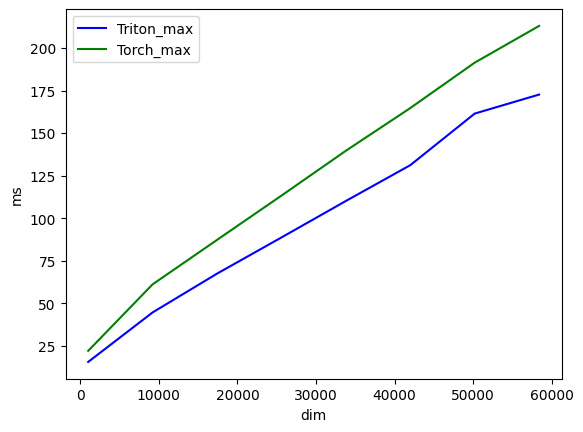

triton max:
       dim  Triton_max   Torch_max
0   1024.0   15.671197   22.181587
1   9216.0   44.731263   61.220683
2  17408.0   67.496374   87.304540
3  25600.0   88.738292  113.300592
4  33792.0  110.158131  139.631405
5  41984.0  131.179675  164.702311
6  50176.0  161.465436  191.367984
7  58368.0  172.628328  212.930188


In [11]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 64+1, 8)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2048, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


# 小dim benchmark

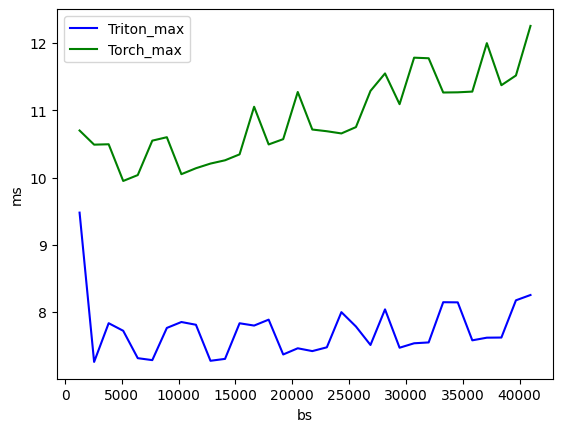

triton max:
         bs  Triton_max  Torch_max
0    1280.0    9.478737  10.699689
1    2560.0    7.258985  10.489408
2    3840.0    7.834785  10.495137
3    5120.0    7.722017   9.949663
4    6400.0    7.314828  10.036972
5    7680.0    7.285718  10.548987
6    8960.0    7.764371  10.599965
7   10240.0    7.852366  10.050445
8   11520.0    7.811560  10.138834
9   12800.0    7.275918  10.208091
10  14080.0    7.304145  10.256880
11  15360.0    7.833573  10.344934
12  16640.0    7.799591  11.052709
13  17920.0    7.887492  10.492605
14  19200.0    7.369733  10.571163
15  20480.0    7.461785  11.272352
16  21760.0    7.419895  10.714352
17  23040.0    7.476183  10.688854
18  24320.0    7.999077  10.656222
19  25600.0    7.785724  10.750340
20  26880.0    7.510856  11.288428
21  28160.0    8.040230  11.548323
22  29440.0    7.470085  11.091028
23  30720.0    7.536130  11.782599
24  32000.0    7.548786  11.774011
25  33280.0    8.146740  11.264733
26  34560.0    8.144552  11.267535
27  3584

In [28]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


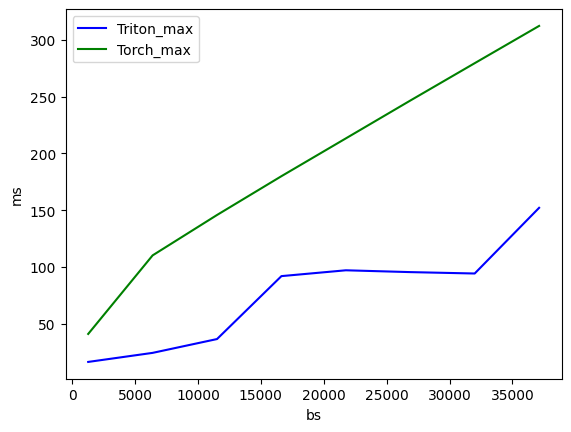

triton max:
        bs  Triton_max   Torch_max
0   1280.0   16.154224   40.834486
1   6400.0   24.137581  110.124141
2  11520.0   36.327973  145.761341
3  16640.0   91.840588  179.990873
4  21760.0   96.974500  213.319138
5  26880.0   95.367901  246.671915
6  32000.0   94.138935  279.642344
7  37120.0  152.073503  312.511355


In [9]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1, 4)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096, 'axis': 0}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
